# Deep Reinforcement Learning with Kaggle Environments

author: kogni7

date: 2022/23

In this notebook, we use Deep Reinforcement Learning and the functionality of Gym and Stable-Baselines3 to train bots that can compete in tictactoe and connectx from Kaggle Environments.

References:
* https://www.kaggle.com/alexisbcook/deep-reinforcement-learning
* https://www.gymlibrary.dev
* https://stable-baselines3.readthedocs.io
* https://github.com/Kaggle/kaggle-environments

## Installations and Libraries

In [1]:
%%capture
!pip install --upgrade pip
!pip install --upgrade kaggle-environments
!pip install --upgrade stable-baselines3
!pip install --upgrade mlflow

In [2]:
%%capture

import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import mlflow

import gym

from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import HumanOutputFormat, KVWriter, Logger
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import set_random_seed

from kaggle_environments import evaluate, helpers, make
from kaggle_environments.envs.halite.helpers import *

## TicTacToe: random_agent

### The Environment!

In [3]:
class TicTacToeGym(gym.Env):
    def __init__(self):
        super(TicTacToeGym, self).__init__()
        env = make("tictactoe", debug=True)
        self.env = env.train([None, "random"])
        self.action_space = gym.spaces.Discrete(9)
        self.observation_space = gym.spaces.Box(low=0, high=2, shape=(1, 3, 3), dtype=np.uint8)
        self.reward_range = (-10, 1)

    def step(self, action):
        board = np.array(self.observation.board).reshape(1, 3, 3).astype(np.uint8)
        action_is_valid = True if board[0, action//3, action%3] == 0 else False
            
        if action_is_valid:
            self.observation, reward, done, _ = self.env.step(int(action))
            if done: # game has ended
                reward, done, _ = reward, done, {}
        else: # invalid action
            reward, done, _ = -10, True, {}

        return np.array(self.observation.board).reshape(1, 3, 3).astype(np.uint8), reward, done, _

    def reset(self): # the state
        self.observation = self.env.reset()
        return np.array(self.observation.board).reshape(1, 3, 3).astype(np.uint8)

env = TicTacToeGym()
check_env(env)

/opt/conda/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:39: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  f"It seems that your observation space {key} is an image but the "
/opt/conda/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:52: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  "The minimal resolution for an image is 36x36 for the default `CnnPolicy`. "


### The Net!

In [4]:
class ActionValuesCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features=128):
        super(ActionValuesCNN, self).__init__(observation_space, features)
        self.cnn1 = nn.Conv2d(observation_space.shape[0], 32, kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        # Calculate n_flatten with the formula under https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html - Shape
        # C_out=32, H_out=W_out=2
        n_flatten = 2**2*32
        self.linear = nn.Linear(n_flatten, features)
        
    def forward(self, observations):
        cnn1 = self.relu(self.cnn1(observations))
        flatten = self.flatten(cnn1)
        linear = self.relu(self.linear(flatten))
        return linear    

ActionValuesCNN(gym.spaces.Box(low=0, high=2, shape=(1, 3, 3), dtype=np.uint8))

ActionValuesCNN(
  (cnn1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=128, out_features=128, bias=True)
)

### Training!

In [5]:
#https://stable-baselines3.readthedocs.io/en/master/guide/integrations.html#mlflow
class MLflowOutputFormat(KVWriter):
    def write(self, key_values, key_excluded, step = 0):
        for (key, value) in sorted(key_values.items()):
            mlflow.log_metric(key, value, step)
            
#https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/multiprocessing_rl.ipynb#scrollTo=hyyN-2qyK_T2
def make_env(rank, env, seed=0):
    def _init():
        env.reset()
        return env
    set_random_seed(seed)
    return _init

In [6]:
loggers = Logger(folder=None, output_formats=[MLflowOutputFormat()])

policy_kwargs = dict(features_extractor_class=ActionValuesCNN,)

env = SubprocVecEnv([make_env(i, env) for i in range(4)])

with mlflow.start_run() as run:
    model = A2C('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=2)
    print(model.policy)
    model.set_logger(loggers)
    model.learn(total_timesteps=100000, log_interval=1, progress_bar=True)
    run_id = run.info.run_id
del env

Output()

Using cpu device
ActorCriticCnnPolicy(
  (features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (pi_features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (vf_features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (

### Statistics!

<AxesSubplot:xlabel='timesteps', ylabel='explained_variance'>

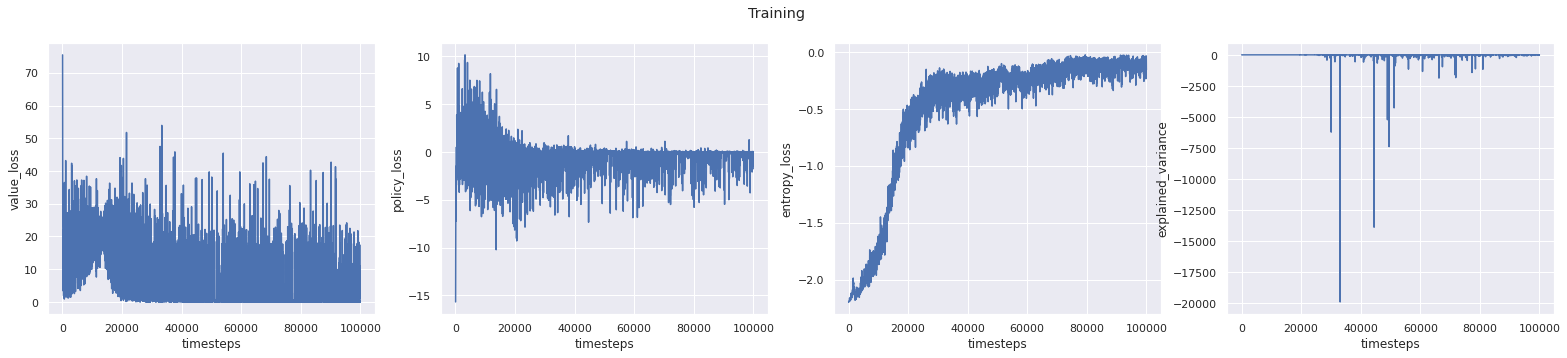

In [7]:
with open('mlruns/0/' + run_id +'/metrics/train/value_loss') as value_loss:
    value_loss_lines = value_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/policy_loss') as policy_loss:
    policy_loss_lines = policy_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/entropy_loss') as entropy_loss:
    entropy_loss_lines = entropy_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/explained_variance') as explained_variance:
    explained_variance_lines = explained_variance.readlines()

data = {}
data["timesteps"] = [int(item.split(" ")[2]) for item in value_loss_lines]
data["value_loss"] = [float(item.split(" ")[1]) for item in value_loss_lines]
data["policy_loss"] = [float(item.split(" ")[1]) for item in policy_loss_lines]
data["entropy_loss"] = [float(item.split(" ")[1]) for item in entropy_loss_lines]
data["explained_variance"] = [float(item.split(" ")[1]) for item in explained_variance_lines]

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1, 4, figsize=(27, 5))
fig.suptitle("Training")
sns.lineplot(ax=axes[0], x="timesteps", y="value_loss", data=data)
sns.lineplot(ax=axes[1], x="timesteps", y="policy_loss", data=data)
sns.lineplot(ax=axes[2], x="timesteps", y="entropy_loss", data=data)
sns.lineplot(ax=axes[3], x="timesteps", y="explained_variance", data=data)

### 

### Show!

In [8]:
def agent(observation, configuration):
    board = np.array(observation.board).reshape(1, 3, 3).astype(np.uint8)
    action, _ = model.predict(board, deterministic=True)

    return int(action)

env = make("tictactoe", debug=True)
env.run([agent, "random"])
env.render(mode="ipython")

### Evaluate the trained Agent!

In [9]:
n_rounds = 100

games = [evaluate("tictactoe", [agent, "random"], {}, num_episodes=1)[0] for _ in range(n_rounds//2)]
games += [[b,a] for [a,b] in [evaluate("tictactoe", ["random", agent], {}, num_episodes=1)[0] for _ in range(n_rounds//2)]]

games_won = sum([game[0] if game[0] is not None and game[0] > 0 else 0 for game in games])
games_lost = abs(sum([x[0] if x[0] is not None and x[0] < 0 else 0 for x in games]))
games_tie = sum([1 if x[0] == x[1] and x[0] is not None else 0 for x in games])
games_invalid = sum([1 if x[0] is None else 0 for x in games])

print("The trained Agent won {} of {} played games.".format(int(games_won), n_rounds))
print("The trained Agent lost {} of {} played games.".format(int(games_lost), n_rounds))
print("{} of {} played games were a tie.".format(int(games_tie), n_rounds))
print("The trained Agent had played invalidly {} of {} played games.".format(int(games_invalid), n_rounds))

The trained Agent won 71 of 100 played games.
The trained Agent lost 17 of 100 played games.
7 of 100 played games were a tie.
The trained Agent had played invalidly 5 of 100 played games.


## TicTacToe: reaction_agent

### The Environment!

In [10]:
class TicTacToeGym(gym.Env):
    def __init__(self):
        super(TicTacToeGym, self).__init__()
        env = make("tictactoe", debug=True)
        self.env = env.train([None, "reaction"])
        self.action_space = gym.spaces.Discrete(9)
        self.observation_space = gym.spaces.Box(low=0, high=2, shape=(1, 3, 3), dtype=np.uint8)
        self.reward_range = (-10, 1)

    def step(self, action):
        board = np.array(self.observation.board).reshape(1, 3, 3).astype(np.uint8)
        action_is_valid = True if board[0, action//3, action%3] == 0 else False
            
        if action_is_valid:
            self.observation, reward, done, _ = self.env.step(int(action))
            if done: # game has ended
                if reward == 1: # win
                    reward, done, _ = reward, done, {}
                else: # tie or loss
                    reward, done, _ = -1, done, {}
            else:
                reward, done, _ = 1/5, done, {}
        else: # invalid action
            reward, done, _ = -10, True, {}

        return np.array(self.observation.board).reshape(1, 3, 3).astype(np.uint8), reward, done, _

    def reset(self): # the state
        self.observation = self.env.reset()
        return np.array(self.observation.board).reshape(1, 3, 3).astype(np.uint8)

env = TicTacToeGym()
check_env(env)

/opt/conda/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:39: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  f"It seems that your observation space {key} is an image but the "
/opt/conda/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:52: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  "The minimal resolution for an image is 36x36 for the default `CnnPolicy`. "


### Training!

In [11]:
loggers = Logger(folder=None, output_formats=[MLflowOutputFormat()])

policy_kwargs = dict(features_extractor_class=ActionValuesCNN,)

env = SubprocVecEnv([make_env(i, env) for i in range(4)])

with mlflow.start_run() as run:
    model = A2C('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=2)
    print(model.policy)
    model.set_logger(loggers)
    model.learn(total_timesteps=300000, log_interval=1, progress_bar=True)
    run_id = run.info.run_id
del env

Output()

Using cpu device
ActorCriticCnnPolicy(
  (features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (pi_features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (vf_features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (

### Statistics!

<AxesSubplot:xlabel='timesteps', ylabel='explained_variance'>

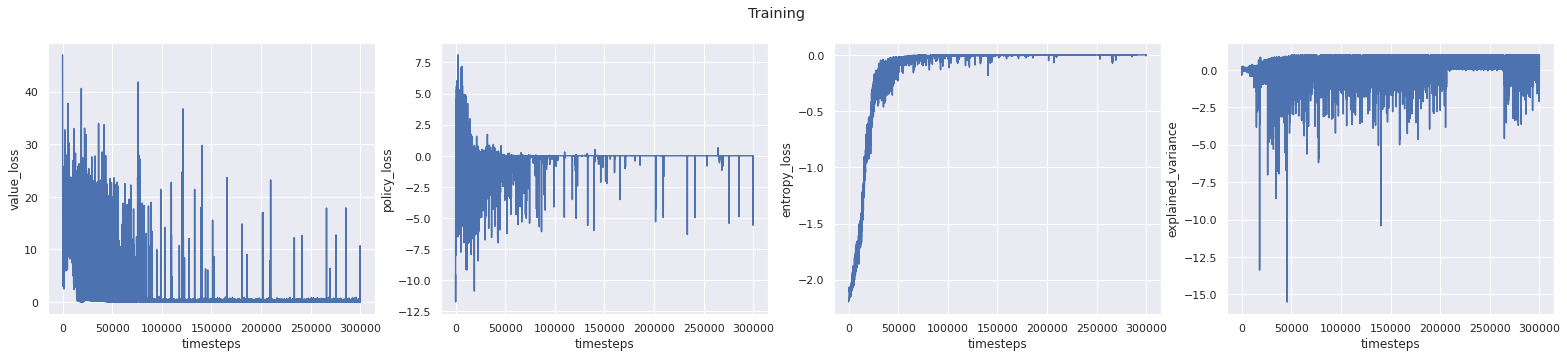

In [12]:
with open('mlruns/0/' + run_id +'/metrics/train/value_loss') as value_loss:
    value_loss_lines = value_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/policy_loss') as policy_loss:
    policy_loss_lines = policy_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/entropy_loss') as entropy_loss:
    entropy_loss_lines = entropy_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/explained_variance') as explained_variance:
    explained_variance_lines = explained_variance.readlines()

data = {}
data["timesteps"] = [int(item.split(" ")[2]) for item in value_loss_lines]
data["value_loss"] = [float(item.split(" ")[1]) for item in value_loss_lines]
data["policy_loss"] = [float(item.split(" ")[1]) for item in policy_loss_lines]
data["entropy_loss"] = [float(item.split(" ")[1]) for item in entropy_loss_lines]
data["explained_variance"] = [float(item.split(" ")[1]) for item in explained_variance_lines]

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1, 4, figsize=(27, 5))
fig.suptitle("Training")
sns.lineplot(ax=axes[0], x="timesteps", y="value_loss", data=data)
sns.lineplot(ax=axes[1], x="timesteps", y="policy_loss", data=data)
sns.lineplot(ax=axes[2], x="timesteps", y="entropy_loss", data=data)
sns.lineplot(ax=axes[3], x="timesteps", y="explained_variance", data=data)

### Show!

In [13]:
def agent(observation, configuration):
    board = np.array(observation.board).reshape(1, 3, 3).astype(np.uint8)
    action, _ = model.predict(board, deterministic=True)

    return int(action)

env = make("tictactoe", debug=True)
env.run([agent, "reaction"])
env.render(mode="ipython")

### Evaluate the trained Agent!

In [14]:
n_rounds = 100

games = [evaluate("tictactoe", [agent, "reaction"], {}, num_episodes=1)[0] for _ in range(n_rounds//2)]
games += [[b,a] for [a,b] in [evaluate("tictactoe", ["reaction", agent], {}, num_episodes=1)[0] for _ in range(n_rounds//2)]]

games_won = sum([game[0] if game[0] is not None and game[0] > 0 else 0 for game in games])
games_lost = abs(sum([x[0] if x[0] is not None and x[0] < 0 else 0 for x in games]))
games_tie = sum([1 if x[0] == x[1] and x[0] is not None else 0 for x in games])
games_invalid = sum([1 if x[0] is None else 0 for x in games])

print("The trained Agent won {} of {} played games.".format(int(games_won), n_rounds))
print("The trained Agent lost {} of {} played games.".format(int(games_lost), n_rounds))
print("{} of {} played games were a tie.".format(int(games_tie), n_rounds))
print("The trained Agent had played invalidly {} of {} played games.".format(int(games_invalid), n_rounds))

The trained Agent won 52 of 100 played games.
The trained Agent lost 33 of 100 played games.
0 of 100 played games were a tie.
The trained Agent had played invalidly 15 of 100 played games.


## ConnectX: random_agent

### The Environment!

In [15]:
class ConnectXGym(gym.Env):
    def __init__(self):
        super(ConnectXGym, self).__init__()
        env = make("connectx", debug=True)
        self.env = env.train([None, "random"])
        self.action_space = gym.spaces.Discrete(7)
        self.observation_space = gym.spaces.Box(low=0, high=2, shape=(1, 6, 7), dtype=np.uint8)
        self.reward_range = (-10, 1)

    def step(self, action):
        board = np.array(self.observation.board).reshape(1, 6, 7).astype(np.uint8)

        action_is_valid = True if board[0, 0, action] == 0 else False
            
        if action_is_valid:
            self.observation, reward, done, _ = self.env.step(int(action))
            if done: # game has ended
                reward, done, _ = reward, done, {}
        else: # invalid action
            reward, done, _ = -10, True, {}

        return np.array(self.observation.board).reshape(1, 6, 7).astype(np.uint8), reward, done, _

    def reset(self): # the state
        self.observation = self.env.reset()
        return np.array(self.observation.board).reshape(1, 6, 7).astype(np.uint8)

env = ConnectXGym()
check_env(env)

/opt/conda/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:39: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  f"It seems that your observation space {key} is an image but the "
/opt/conda/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:52: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  "The minimal resolution for an image is 36x36 for the default `CnnPolicy`. "


### The Net!

In [16]:
class ActionValuesCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features=128):
        super(ActionValuesCNN, self).__init__(observation_space, features)
        self.cnn1 = nn.Conv2d(observation_space.shape[0], 32, kernel_size=3)
        self.cnn2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        # Calculate n_flatten with the formula under https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html - Shape
        # C_out=64, H_out=2, W_out=3
        n_flatten = 2*3*64
        self.linear = nn.Linear(n_flatten, features)
        
    def forward(self, observations):
        cnn1 = self.relu(self.cnn1(observations))
        cnn2 = self.relu(self.cnn2(cnn1))
        flatten = self.flatten(cnn2)
        linear = self.relu(self.linear(flatten))
        return linear    

ActionValuesCNN(gym.spaces.Box(low=0, high=2, shape=(1, 6, 7), dtype=np.uint8))

ActionValuesCNN(
  (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=384, out_features=128, bias=True)
)

### Training!

In [17]:
loggers = Logger(folder=None, output_formats=[MLflowOutputFormat()])

policy_kwargs = dict(features_extractor_class=ActionValuesCNN,)

env = SubprocVecEnv([make_env(i, env) for i in range(4)])

with mlflow.start_run() as run:
    model = A2C('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=2)
    print(model.policy)
    model.set_logger(loggers)
    model.learn(total_timesteps=100000, log_interval=1, progress_bar=True)
    run_id = run.info.run_id
del env

Using cpu device
ActorCriticCnnPolicy(
  (features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=384, out_features=128, bias=True)
  )
  (pi_features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=384, out_features=128, bias=True)
  )
  (vf_features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=384, out_features=128, bias=True)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net)

Output()

### Statistics!

<AxesSubplot:xlabel='timesteps', ylabel='explained_variance'>

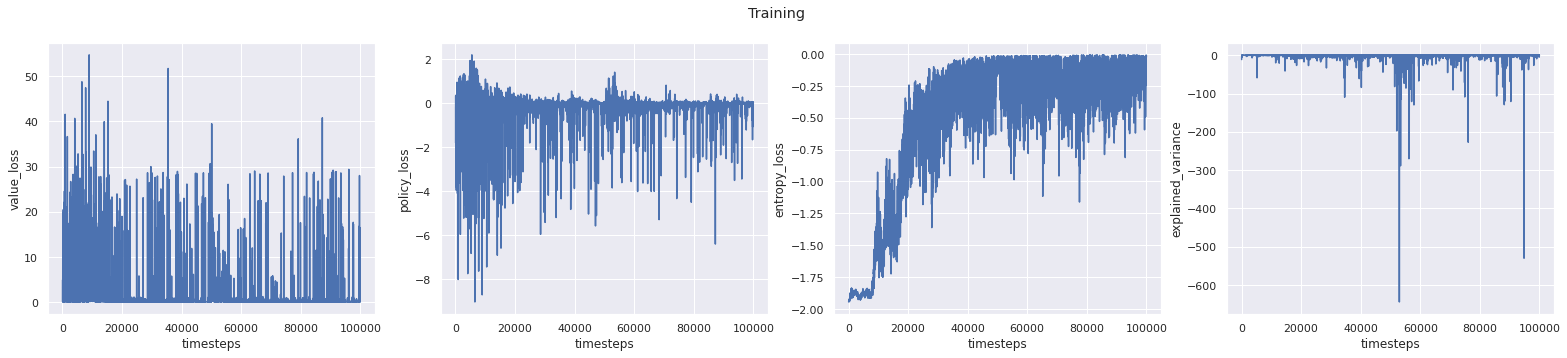

In [18]:
with open('mlruns/0/' + run_id +'/metrics/train/value_loss') as value_loss:
    value_loss_lines = value_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/policy_loss') as policy_loss:
    policy_loss_lines = policy_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/entropy_loss') as entropy_loss:
    entropy_loss_lines = entropy_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/explained_variance') as explained_variance:
    explained_variance_lines = explained_variance.readlines()

data = {}
data["timesteps"] = [int(item.split(" ")[2]) for item in value_loss_lines]
data["value_loss"] = [float(item.split(" ")[1]) for item in value_loss_lines]
data["policy_loss"] = [float(item.split(" ")[1]) for item in policy_loss_lines]
data["entropy_loss"] = [float(item.split(" ")[1]) for item in entropy_loss_lines]
data["explained_variance"] = [float(item.split(" ")[1]) for item in explained_variance_lines]

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1, 4, figsize=(27, 5))
fig.suptitle("Training")
sns.lineplot(ax=axes[0], x="timesteps", y="value_loss", data=data)
sns.lineplot(ax=axes[1], x="timesteps", y="policy_loss", data=data)
sns.lineplot(ax=axes[2], x="timesteps", y="entropy_loss", data=data)
sns.lineplot(ax=axes[3], x="timesteps", y="explained_variance", data=data)

### Show!

In [19]:
def agent(observation, configuration):
    board = np.array(observation.board).reshape(1, 6, 7).astype(np.uint8)
    action, _ = model.predict(board, deterministic=True)

    return int(action)

env = make("connectx", debug=True)
env.run([agent, "random"])
env.render(mode="ipython")

Invalid Action: Invalid column: 1


### Evaluate the trained Agent!

In [20]:
n_rounds = 100

games = [evaluate("connectx", [agent, "random"], {}, num_episodes=1)[0] for _ in range(n_rounds//2)]
games += [[b,a] for [a,b] in [evaluate("connectx", ["random", agent], {}, num_episodes=1)[0] for _ in range(n_rounds//2)]]

games_won = sum([game[0] if game[0] is not None and game[0] > 0 else 0 for game in games])
games_lost = abs(sum([x[0] if x[0] is not None and x[0] < 0 else 0 for x in games]))
games_tie = sum([1 if x[0] == x[1] and x[0] is not None else 0 for x in games])
games_invalid = sum([1 if x[0] is None else 0 for x in games])

print("The trained Agent won {} of {} played games.".format(int(games_won), n_rounds))
print("The trained Agent lost {} of {} played games.".format(int(games_lost), n_rounds))
print("{} of {} played games were a tie.".format(int(games_tie), n_rounds))
print("The trained Agent had played invalidly {} of {} played games.".format(int(games_invalid), n_rounds))

The trained Agent won 89 of 100 played games.
The trained Agent lost 11 of 100 played games.
0 of 100 played games were a tie.
The trained Agent had played invalidly 0 of 100 played games.


## ConnectX: negamax_agent

### The Environment!

In [21]:
class ConnectXGym(gym.Env):
    def __init__(self):
        super(ConnectXGym, self).__init__()
        env = make("connectx", debug=True)
        self.env = env.train([None, "negamax"])
        self.action_space = gym.spaces.Discrete(7)
        self.observation_space = gym.spaces.Box(low=0, high=2, shape=(1, 6, 7), dtype=np.uint8)
        self.reward_range = (-10, 1)

    def step(self, action):
        board = np.array(self.observation.board).reshape(1, 6, 7).astype(np.uint8)

        action_is_valid = True if board[0, 0, action] == 0 else False

        if action_is_valid:
            self.observation, reward, done, _ = self.env.step(int(action))
            if done: # game has ended
                if reward == 1: # win
                    reward, done, _ = reward, done, {}
                else: # tie or loss
                    reward, done, _ = -1, done, {}
            else:
                reward, done, _ = 1/21, done, {}
        else: # invalid action
            reward, done, _ = -10, True, {}

        return np.array(self.observation.board).reshape(1, 6, 7).astype(np.uint8), reward, done, _

    def reset(self): # the state
        self.observation = self.env.reset()
        return np.array(self.observation.board).reshape(1, 6, 7).astype(np.uint8)

env = ConnectXGym()
check_env(env)

/opt/conda/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:39: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  f"It seems that your observation space {key} is an image but the "
/opt/conda/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:52: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  "The minimal resolution for an image is 36x36 for the default `CnnPolicy`. "


### The Net!

In [22]:
loggers = Logger(folder=None, output_formats=[MLflowOutputFormat()])

policy_kwargs = dict(features_extractor_class=ActionValuesCNN,)

env = SubprocVecEnv([make_env(i, env) for i in range(4)])

with mlflow.start_run() as run:
    model = A2C('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=2)
    print(model.policy)
    model.set_logger(loggers)
    model.learn(total_timesteps=50000, log_interval=1, progress_bar=True)
    run_id = run.info.run_id
del env

Using cpu device
ActorCriticCnnPolicy(
  (features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=384, out_features=128, bias=True)
  )
  (pi_features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=384, out_features=128, bias=True)
  )
  (vf_features_extractor): ActionValuesCNN(
    (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=384, out_features=128, bias=True)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net)

Output()

### Statistics!

<AxesSubplot:xlabel='timesteps', ylabel='explained_variance'>

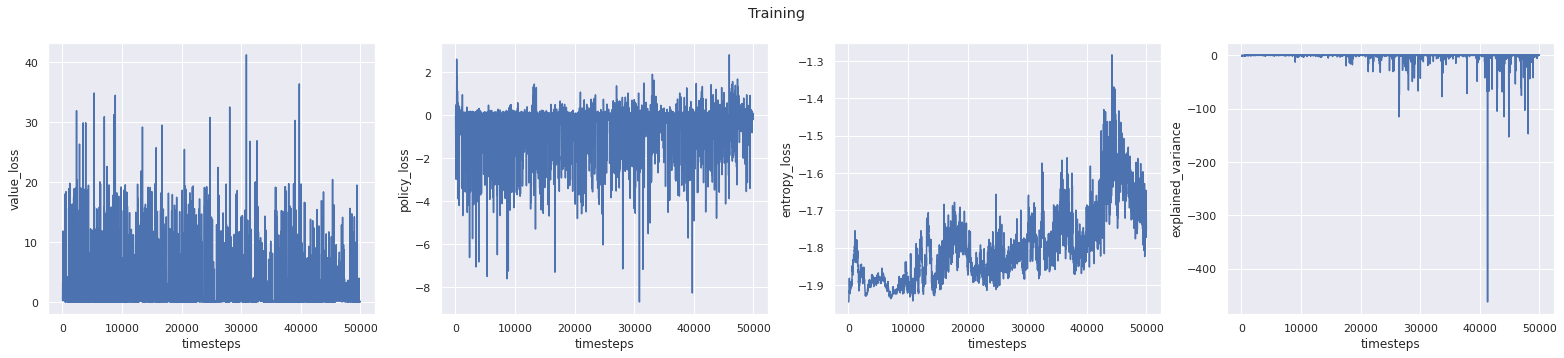

In [23]:
with open('mlruns/0/' + run_id +'/metrics/train/value_loss') as value_loss:
    value_loss_lines = value_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/policy_loss') as policy_loss:
    policy_loss_lines = policy_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/entropy_loss') as entropy_loss:
    entropy_loss_lines = entropy_loss.readlines()
with open('mlruns/0/' + run_id + '/metrics/train/explained_variance') as explained_variance:
    explained_variance_lines = explained_variance.readlines()

data = {}
data["timesteps"] = [int(item.split(" ")[2]) for item in value_loss_lines]
data["value_loss"] = [float(item.split(" ")[1]) for item in value_loss_lines]
data["policy_loss"] = [float(item.split(" ")[1]) for item in policy_loss_lines]
data["entropy_loss"] = [float(item.split(" ")[1]) for item in entropy_loss_lines]
data["explained_variance"] = [float(item.split(" ")[1]) for item in explained_variance_lines]

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1, 4, figsize=(27, 5))
fig.suptitle("Training")
sns.lineplot(ax=axes[0], x="timesteps", y="value_loss", data=data)
sns.lineplot(ax=axes[1], x="timesteps", y="policy_loss", data=data)
sns.lineplot(ax=axes[2], x="timesteps", y="entropy_loss", data=data)
sns.lineplot(ax=axes[3], x="timesteps", y="explained_variance", data=data)

### Show!

In [24]:
def agent(observation, configuration):
    board = np.array(observation.board).reshape(1, 6, 7).astype(np.uint8)
    action, _ = model.predict(board, deterministic=True)

    return int(action)

env = make("connectx", debug=True)
env.run([agent, "negamax"])
env.render(mode="ipython")

### Evaluate the trained Agent!

In [25]:
n_rounds = 100

games = [evaluate("connectx", [agent, "negamax"], {}, num_episodes=1)[0] for _ in range(n_rounds//2)]
games += [[b,a] for [a,b] in [evaluate("connectx", ["negamax", agent], {}, num_episodes=1)[0] for _ in range(n_rounds//2)]]

games_won = sum([game[0] if game[0] is not None and game[0] > 0 else 0 for game in games])
games_lost = abs(sum([x[0] if x[0] is not None and x[0] < 0 else 0 for x in games]))
games_tie = sum([1 if x[0] == x[1] and x[0] is not None else 0 for x in games])
games_invalid = sum([1 if x[0] is None else 0 for x in games])

print("The trained Agent won {} of {} played games.".format(int(games_won), n_rounds))
print("The trained Agent lost {} of {} played games.".format(int(games_lost), n_rounds))
print("{} of {} played games were a tie.".format(int(games_tie), n_rounds))
print("The trained Agent had played invalidly {} of {} played games.".format(int(games_invalid), n_rounds))

The trained Agent won 12 of 100 played games.
The trained Agent lost 68 of 100 played games.
0 of 100 played games were a tie.
The trained Agent had played invalidly 20 of 100 played games.
